# VGG16

In [1]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(os.listdir("./"))

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term
['.ipynb_checkpoints', 'method2.ipynb', 'ResNet50.ipynb', 'submissions', 'test1', 'test1.zip', 'train', 'train.zip', 'VGG16.ipynb', 'VGG19.ipynb']


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

## Step1: Load the Traning Data

In [3]:
filenames = os.listdir(".\\train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


## Step2: Build Model

In [4]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
__________________________________________________________

## Step3: Prepare Test and Train Data

In [5]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
train_df["category"] = train_df["category"].astype(str)
validate_df["category"] = validate_df["category"].astype(str)

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 22500 validated image filenames belonging to 2 classes.


In [7]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    steps_per_epoch=len(train_df),
    batch_size=batch_size
)

Found 2500 validated image filenames belonging to 2 classes.


## Step4: Fit Model

In [8]:
# fine-tune the model
history = model.fit_generator(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/5
1406/1406 [==============================] - 447s 318ms/step - loss: 0.2999 - acc: 0.8602 - val_loss: 0.1213 - val_acc: 0.9495
Epoch 2/5
1406/1406 [==============================] - 444s 316ms/step - loss: 0.1534 - acc: 0.9372 - val_loss: 0.0966 - val_acc: 0.9650
Epoch 3/5
1406/1406 [==============================] - 456s 324ms/step - loss: 0.1263 - acc: 0.9489 - val_loss: 0.0833 - val_acc: 0.9658
Epoch 4/5
1406/1406 [==============================] - 468s 333ms/step - loss: 0.1092 - acc: 0.9567 - val_loss: 0.0753 - val_acc: 0.9694
Epoch 5/5
1406/1406 [==============================] - 450s 320ms/step - loss: 0.1035 - acc: 0.9573 - val_loss: 0.0891 - val_acc: 0.9658


In [9]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.965378  ;  loss = 0.088361 


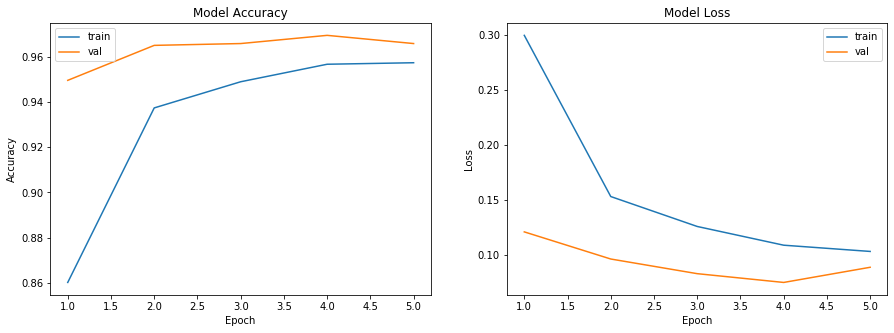

In [10]:
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

## Step5: Testing Data

In [11]:
test_filenames = os.listdir("./test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [12]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 12500 validated image filenames.


In [13]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

## Step6: Result

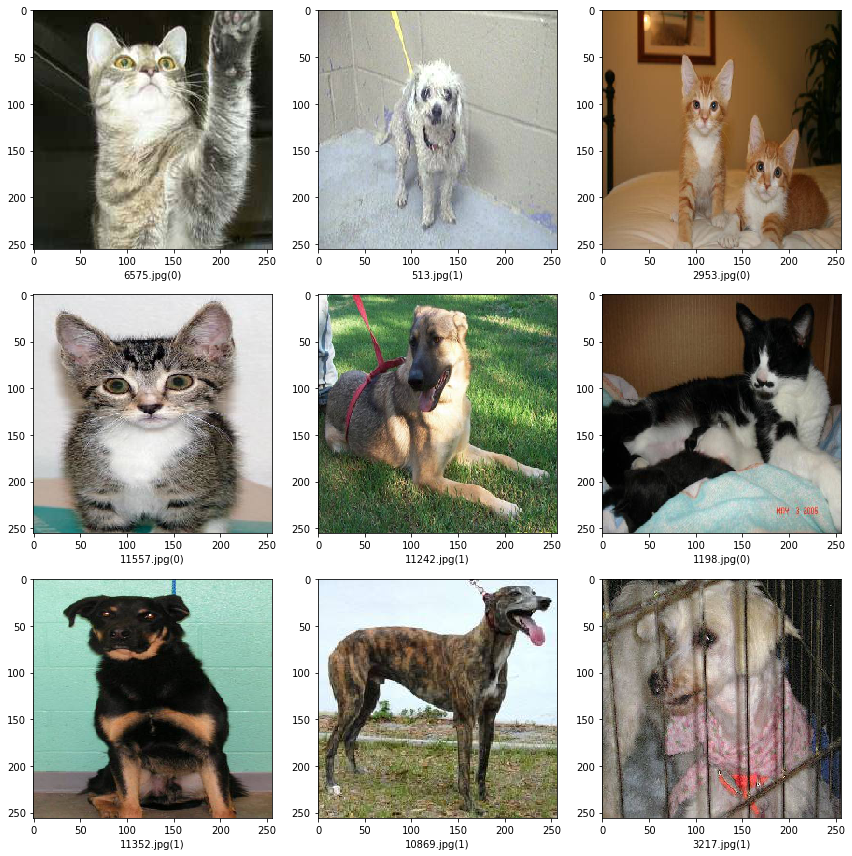

In [14]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

## Step7: Create Submission

In [15]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('./submissions/submission_VGG16.csv', index=False)